In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt
from math import lcm

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=hcf.PS_choffs) 
mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
# set MW frequency =====================================================
f_NVguess = 398.556
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.6065 GHz
Actual Output CW Freqeuncy :16.60650000348687 GHz


In [4]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)

# set MW reflection monitoring =====================================================

srate_zbd = hcf.NI_sampling_max # Hz
dt_zbd = int(1/srate_zbd*1E9) # ns
task_zbd = nidaqmx.Task("ZBD") # user controlled attenuation
task_zbd.ai_channels.add_ai_voltage_chan(hcf.NI_ch_ZBD, min_val=-10.0, max_val=10)
task_zbd.timing.cfg_samp_clk_timing(srate_zbd, 
                                    source=hcf.NI_ch_Clock, 
                                    active_edge=Edge.RISING,
                                    sample_mode=AcquisitionType.CONTINUOUS)
num_read = int(0.1*srate_zbd) # say acquire for 0.1s
sw_period = int(100E3) # [ns]
leastrepeat = lcm(dt_zbd, sw_period)


pg.resetSeq()
pg.setDigital("dtrig", [(dt_zbd/2.0, HIGH), (dt_zbd/2.0, LOW)], offset=True)
pg.setDigital("mwA", [(sw_period/2.0, LOW), (sw_period/2.0, LOW)]*int(leastrepeat/sw_period), offset=True)
pg.setDigital("mwB", [(sw_period/2.0, LOW), (sw_period/2.0, HIGH)]*int(leastrepeat/sw_period), offset=True)
pg.setDigital("dclk", [(dt_zbd/2.0, LOW), (dt_zbd/2.0, HIGH)]*int(leastrepeat/dt_zbd), offset=True)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
pg.stream(n_runs=REPEAT_INFINITELY)

task_zbd_readtrig = task_zbd.triggers.start_trigger
task_zbd_readtrig.cfg_dig_edge_start_trig(
    hcf.NI_ch_Trig, Edge.RISING
)
task_zbd_readtrig.cfg_dig_edge_start_trig(hcf.NI_ch_Trig, Edge.RISING)
task_zbd_reader = AnalogSingleChannelReader(task_zbd.in_stream)
task_zbd_reader.read_all_avail_samp  = True



# Start the task
task_zbd.start()
pg.startNow()
# zbddata = []
# for _ in range(1000):  # Read 10 values
#     value = task_zbd.read()  # Read a single sample
#     zbddata.append(value)
#     print(f"Analog Value: {value}")
zbd_samples = task_zbd.read(number_of_samples_per_channel=num_read, timeout=10.0)
zbd_buffer = np.zeros(num_read, dtype=np.float64, order='C')

task_zbd_reader.read_many_sample(
        zbd_buffer, 
        number_of_samples_per_channel=num_read,
        timeout=10.0
    )
zbd_samples = zbd_buffer

pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()

task_zbd.stop()
task_zbd.close()
task_uca.stop()
task_uca.close()

mwsyn.close()

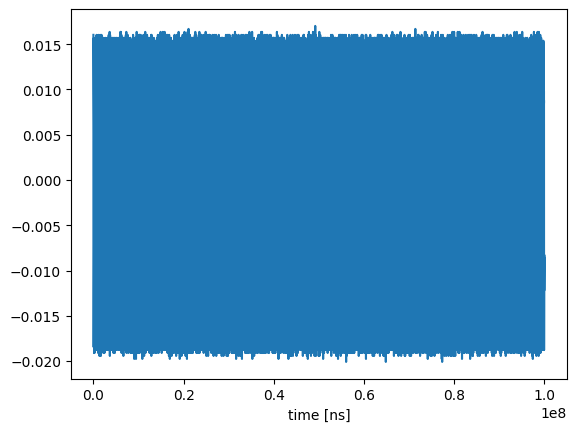

In [5]:
dt = 1E9/srate_zbd # ns
zbd_time = np.arange(0, num_read*dt, dt)
plt.plot(zbd_time, zbd_samples)
plt.xlabel("time [ns]")
plt.show()

In [6]:
num_pt = len(zbd_samples)
div = int(sw_period/dt_zbd*2)
zbd_samples_reshape = np.reshape(zbd_samples, (int(num_pt/div), div))
zbd_t = zbd_time[:div]
zbd_sav = np.average(zbd_samples_reshape, axis=0)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# RC square wave model with offset: combines exponential rise and fall with DC offset
def rc_square_wave_with_offset(t, frequency, amplitude, phase, amp_discharge, rc, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase

    # smoothness = 0.2*(t[1]-t[0])
    smoothness = period/1000.0
    smoothedge1 = 1 - np.exp(-t_shifted / smoothness)-np.exp(-(half_period-t_shifted) / smoothness)
    smoothedge2 = 1 - np.exp(-(t_shifted - half_period) / smoothness)-np.exp(-(period-t_shifted) / smoothness)

    rc_wave = np.zeros_like(t)
    flipflop = t_shifted < half_period
    rcwave_fronthalf = (amplitude*smoothedge1-amp_discharge * (1 - np.exp(-t_shifted / rc)))
    rcwave_endhalf = (-amplitude*smoothedge2+amp_discharge * (1 - np.exp(-(t_shifted - half_period) / rc)))
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset

def square_wave_with_offset(t, frequency, amplitude, phase, offset):
    period = 1 / frequency
    half_period = period / 2
    dt = (t[-1]-t[0])/len(t)
    t_shifted = (t + phase / (2 * np.pi * frequency)) % period # Shift by phase
    rc_wave = np.zeros_like(t)
    # smoothness = 0.2*(t[1]-t[0])
    smoothness = period/1000.0
    smoothedge1 = 1 - np.exp(-t_shifted / smoothness)-np.exp(-(half_period-t_shifted) / smoothness)
    smoothedge2 = 1 - np.exp(-(t_shifted - half_period) / smoothness)-np.exp(-(period-t_shifted) / smoothness)
    flipflop = t_shifted < half_period
    rcwave_fronthalf = amplitude*smoothedge1
    rcwave_endhalf = -amplitude*smoothedge2
    rc_wave = flipflop*rcwave_fronthalf + (~flipflop)*rcwave_endhalf
    # Add the offset to the square wave and the RC modification
    return  rc_wave + offset

# get the signal
rescale = 1
t = zbd_t/rescale
signal = zbd_sav

# Initial guesses for the square wave parameters (frequency, amplitude, phase)
# You should provide reasonable initial guesses based on your signal
amp_guess = (np.max(signal)-np.min(signal))/2.0
initial_guess = [1/sw_period*rescale, amp_guess, 0.1, amp_guess, 100E3/rescale, np.mean(signal)]
bounds=([0.0, 0.0, 0.0, 0.0, 0.0, -np.inf], [np.inf, np.inf, np.pi*2.0, np.inf, np.inf, np.inf])

# Fit the RC square wave model with offset to the signal
params_opt, params_cov = curve_fit(rc_square_wave_with_offset, t, signal, p0=initial_guess)
# Reconstruct the signal using the fitted parameters
fitted_signal = rc_square_wave_with_offset(t, *params_opt)



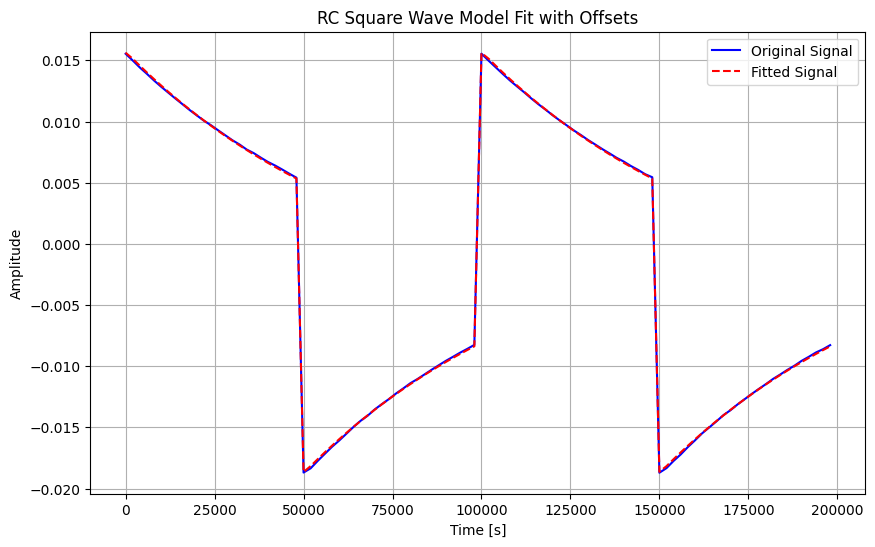

Fitted Parameters:
RC Square Wave 1:
  Frequency: 10.00 kHz
  Amplitude: 17.39 mV
  Phase: 1.88 deg
  Dsicharge Amp.: 21.15 mV
  RC Time Constant: 70.4128 us
  Offset: -1.52 mV


In [15]:
# Plot the original and fitted signals
plt.figure(figsize=(10, 6))
plt.plot(t, signal, label="Original Signal", color='blue')
plt.plot(t, fitted_signal, label="Fitted Signal", linestyle="--", color='red')
plt.title('RC Square Wave Model Fit with Offsets')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Display the optimized parameters
num_waves = len(params_opt) // 5
print("Fitted Parameters:")
for i in range(num_waves):
    print(f"RC Square Wave {i+1}:")
    print(f"  Frequency: {1E9*params_opt[i*5]/1E3:.2f} kHz")
    print(f"  Amplitude: {params_opt[i*5+1]*1E3:.2f} mV")
    print(f"  Phase: {180/np.pi*params_opt[i*5+2]:.2f} deg")
    print(f"  Dsicharge Amp.: {params_opt[i*5+3]*1E3:.2f} mV")
    print(f"  RC Time Constant: {params_opt[i*5+4]/1E3:.4f} us")
    print(f"  Offset: {params_opt[i*5+5]*1E3:.2f} mV")

In [11]:
1/params_opt[0]/1E3

100.02262717871139